In [26]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary

import numpy as np

from misc.datasets_ae import AutoencoderDataset, MNIST_w_imagesums
from misc.autoencoder import Autoencoder, MNIST_ConvEncoder, MNIST_ConvDecoder
from torchinfo import summary
from ssim import ssim

In [4]:
DEVICE = 'cuda:0'

SEED = 0

torch.backends.cudnn.enabled = False
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data

In [7]:
class IndexDataset(torch.utils.data.Dataset):
    """
    Simple wrapper to get the index of each element in the original dataset
    """
    
    def __init__(self, dataset : torch.utils.data.Dataset):
        """
        Initialization.
        
        Parameters
        ----------
        dataset
            The dataset which to wrap.
        """
        
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        outs = self.dataset[index]
        return index, *outs 

In [19]:
batch_size_train = 512
batch_size_test  = 1024

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = torchvision.datasets.MNIST(root="./files/", download=True, transform=train_transforms)
test_ds = torchvision.datasets.MNIST(root="./files/", download=True, transform=test_transforms, train=False)

aug_ratio = 0.1
train_ds = MNIST_w_imagesums(train_ds, aug_ratio=aug_ratio)

train_ds = AutoencoderDataset(train_ds)
test_ds = AutoencoderDataset(test_ds)

split_1_ds, split_2_ds = torch.utils.data.random_split(train_ds, [len(train_ds) // 2]*2)
split_1_ds = IndexDataset(split_1_ds)
split_2_ds = IndexDataset(split_2_ds)

split1_loader = torch.utils.data.DataLoader(split_1_ds, 
                                            batch_size=batch_size_train, 
                                            shuffle=True, 
                                            num_workers=8,
                                            pin_memory=True)
split2_loader = torch.utils.data.DataLoader(split_2_ds, 
                                            batch_size=batch_size_train, 
                                            shuffle=True, 
                                            num_workers=8,
                                            pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=False)

# Training model

In [102]:
def log_mse(logits, targets, sample_idx, sample_mse_list):
    sample_mse = torch.mean((logits - targets)**2, axis=(1,2,3)).cpu().numpy()
    sample_mse = np.hstack([sample_idx.numpy().reshape(-1, 1), sample_mse.reshape(-1, 1)])
    sample_mse_list.append(sample_mse)
    return sample_mse_list

def log_ssim(logits, targets, sample_idx, sample_ssim_list):
    sample_ssim = ssim(logits, targets, size_average=False, win_size=11, data_range=1.0).cpu().numpy()
    sample_ssim = np.hstack([sample_idx.numpy().reshape(-1, 1), sample_ssim.reshape(-1, 1)])
    sample_ssim_list.append(sample_ssim)
    return sample_ssim_list
    
def train(model, epoch, train_loader, loss_fn, log_loader=None, log_step_rel=1.0):
    model.train()
    sample_mse = []
    sample_ssim = []
    train_losses = []

    if log_loader is None:
        log_loader = train_loader
        log_step = None
    else:
        log_step = int(log_step_rel * len(train_loader))

    for step, (sample_idx, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        logits = model(data)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()

        ### sample_scores calculation
        if log_step is None:
            log_mse(logits.detach(), target, sample_idx, sample_mse)
            log_ssim(logits.detach(), target, sample_idx, sample_ssim)
        elif step % log_step == 0:
            mse_log, ssim_log = test(model, log_loader)
            sample_mse.append(mse_log)
            sample_ssim.append(ssim_log)
            model.train()

        train_losses.append(loss.item())
    
    sample_mse = np.vstack(sample_mse)
    sample_ssim = np.vstack(sample_ssim)
    
    return train_losses, sample_mse, sample_ssim

In [114]:
def test(model, test_loader):
    model.eval()
    sample_mse = []
    sample_ssim = []
    
    with torch.no_grad():
        for sample_idx, data, target in test_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            logits = model(data)

            log_mse(logits.detach(), target, sample_idx, sample_mse)
            log_ssim(logits.detach(), target, sample_idx, sample_ssim)

    sample_mse = np.vstack(sample_mse)
    sample_ssim = np.vstack(sample_ssim)
    
    return sample_mse, sample_ssim

# SSFT

### First Split Training

In [116]:
learning_rate = 1e-2
loss_fn = torch.nn.MSELoss()
n_epochs = 500

latent_dim = 10             
model = Autoencoder(
    MNIST_ConvEncoder(latent_dim=latent_dim), 
    MNIST_ConvDecoder(latent_dim=latent_dim)).to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [117]:
# t = split1_loader
# split1_loader = split2_loader
# split2_loader = t
# curr_split_ds = split_2_ds
# print('Swapped split_1 and split_2')

In [118]:
from tqdm.auto import tqdm


sample_mse_by_epoch = []
sample_ssim_by_epoch = []
train_losses = []
train_accs = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, sample_mse, sample_ssim = train(model, epoch, split1_loader, loss_fn)
    
    train_losses.append(losses)
    sample_mse_by_epoch.append(sample_mse)
    sample_ssim_by_epoch.append(sample_ssim)
    
    print(f'Epoch {epoch} loss: {np.mean(losses)}')

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 loss: 0.9934804035084588
Epoch 2 loss: 0.7903375093426023
Epoch 3 loss: 0.7055046185851097
Epoch 4 loss: 0.7022236021501678
Epoch 5 loss: 0.6994750105908939
Epoch 6 loss: 0.6942718720861843
Epoch 7 loss: 0.6829781266195434
Epoch 8 loss: 0.6715465379612786
Epoch 9 loss: 0.6626121561442103
Epoch 10 loss: 0.6559704574091094
Epoch 11 loss: 0.6438171746475356
Epoch 12 loss: 0.6025844131197248
Epoch 13 loss: 0.5657556855252811
Epoch 14 loss: 0.5343722190175738
Epoch 15 loss: 0.5210991310221809
Epoch 16 loss: 0.5020267691995416
Epoch 17 loss: 0.4920482869659151
Epoch 18 loss: 0.4755938707717827
Epoch 19 loss: 0.4682663253375462
Epoch 20 loss: 0.45100190384047373
Epoch 21 loss: 0.43816316393869265
Epoch 22 loss: 0.429499840097768
Epoch 23 loss: 0.4179917478135654
Epoch 24 loss: 0.4075015341596944
Epoch 25 loss: 0.4004164715962751
Epoch 26 loss: 0.3927549214235374
Epoch 27 loss: 0.3868455695254462
Epoch 28 loss: 0.3781933821737766
Epoch 29 loss: 0.37242461847407476
Epoch 30 loss: 0.3657

Epoch 235 loss: 0.2043580516640629
Epoch 236 loss: 0.204108971038035
Epoch 237 loss: 0.20477490100477422
Epoch 238 loss: 0.20426758591617858
Epoch 239 loss: 0.20430749920862062
Epoch 240 loss: 0.20370158260422094
Epoch 241 loss: 0.2063821285430874
Epoch 242 loss: 0.203187850436994
Epoch 243 loss: 0.20347202755510807
Epoch 244 loss: 0.2029619012027979
Epoch 245 loss: 0.20273622710789954
Epoch 246 loss: 0.2033735348709992
Epoch 247 loss: 0.20319235644170217
Epoch 248 loss: 0.2042316874223096
Epoch 249 loss: 0.20322959949927671
Epoch 250 loss: 0.20349734941763536
Epoch 251 loss: 0.20269459885145938
Epoch 252 loss: 0.20273545889982156
Epoch 253 loss: 0.20241796890539782
Epoch 254 loss: 0.20290111883410386
Epoch 255 loss: 0.20142573969704763
Epoch 256 loss: 0.2017050271055528
Epoch 257 loss: 0.20141646984432424
Epoch 258 loss: 0.20160297197954996
Epoch 259 loss: 0.20222840378327028
Epoch 260 loss: 0.20129828580788203
Epoch 261 loss: 0.20293900956000602
Epoch 262 loss: 0.2010689162250076
Epo

Epoch 465 loss: 0.18652888014912605
Epoch 466 loss: 0.1869868239653962
Epoch 467 loss: 0.18598540872335434
Epoch 468 loss: 0.1860342544636556
Epoch 469 loss: 0.1864804050752095
Epoch 470 loss: 0.1858128939888307
Epoch 471 loss: 0.18616571836173534
Epoch 472 loss: 0.1858807892671653
Epoch 473 loss: 0.18559580056795053
Epoch 474 loss: 0.1855972491736923
Epoch 475 loss: 0.18528738218758786
Epoch 476 loss: 0.1865787673741579
Epoch 477 loss: 0.18548766310725892
Epoch 478 loss: 0.18589025097233908
Epoch 479 loss: 0.18544278533330985
Epoch 480 loss: 0.18616719836635248
Epoch 481 loss: 0.18524407036602497
Epoch 482 loss: 0.18609236739575863
Epoch 483 loss: 0.18536984947110927
Epoch 484 loss: 0.18588300395224774
Epoch 485 loss: 0.1850691003991025
Epoch 486 loss: 0.18509981861071928
Epoch 487 loss: 0.1864204779267311
Epoch 488 loss: 0.18551200096096312
Epoch 489 loss: 0.18607594365520136
Epoch 490 loss: 0.1853222075317587
Epoch 491 loss: 0.18500306590327195
Epoch 492 loss: 0.18486471873308932
Ep

In [123]:
step_losses = np.concatenate(train_losses)

epoch_losses = np.mean(train_losses, axis=1)

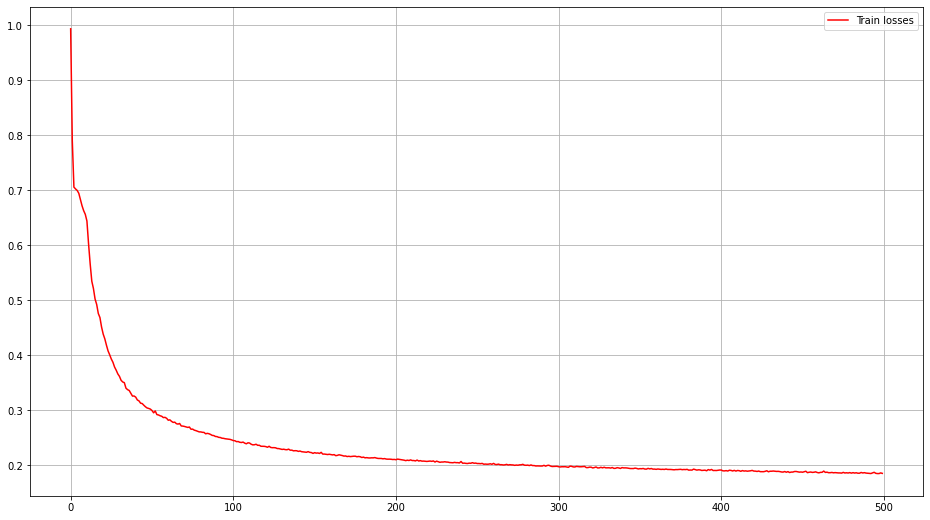

In [124]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_losses, color='red', label='Train losses')
# plt.axhline(1)
plt.grid()
plt.legend()

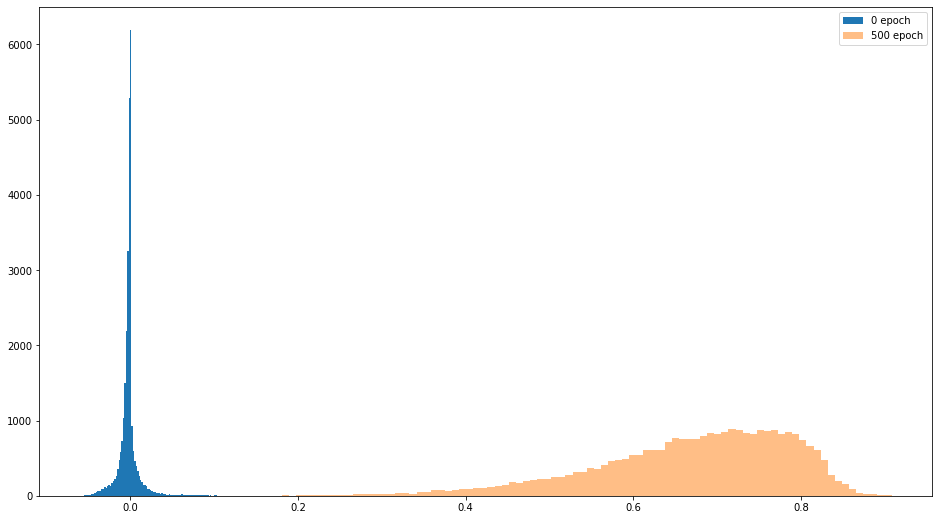

In [248]:
a = np.array(sample_ssim_by_epoch)
epoch_1 = a[0, :, 1]
epoch_250 = a[250, :, 1]
epoch_500 = a[-1, :, 1]

plt.figure(figsize=(16, 9))
plt.hist(epoch_1, bins=100, label='0 epoch')
# plt.hist(epoch_250, bins=100, label='250 epoch', alpha=0.5)
plt.hist(epoch_500, bins=100, label='500 epoch', alpha=0.5)
# plt.ylim(0, 20)
# plt.xlim(0, 0.2)
plt.legend()
plt.show()

### Learning time

In [185]:
def learning_time_from_ssim(sample_scores_by_epoch, thr=0.5):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_scores_by_epoch), total=len(sample_scores_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or score < thr:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if score > thr and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

def learning_time_from_mse(sample_scores_by_epoch, thr):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_scores_by_epoch), total=len(sample_scores_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or score > thr:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if score < thr and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

In [198]:
ssim_learning_times, ssim_learning_times_step = learning_time_from_ssim(sample_ssim_by_epoch, thr=0.5)
mse_learning_times, mse_learning_times_step = learning_time_from_mse(sample_mse_by_epoch, thr=0.65)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [199]:
split_1_metrics_df = pd.DataFrame(
    [(idx, mse_learning_times_step[idx], ssim_learning_times_step[idx]) for idx in mse_learning_times.keys()],
    columns = ['sample_idx', 'mse_learning_time', 'ssim_learning_time']
)

<AxesSubplot:>

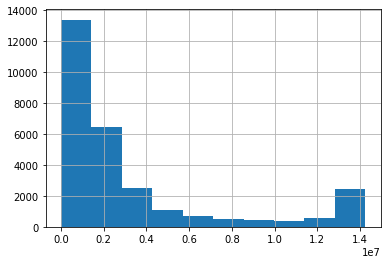

In [200]:
split_1_metrics_df.ssim_learning_time.hist(bins=10)

# Second Split training

In [119]:
from tqdm.auto import tqdm

n_epochs = 500

split_1_sample_mse_by_epoch = []
split_1_sample_ssim_by_epoch = []
split_1_train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, sample_mse, sample_ssim = train(model, epoch, split2_loader, loss_fn, 
                                                      log_loader=split1_loader, log_step_rel=0.25)

    split_1_train_losses.append(losses)
    split_1_sample_mse_by_epoch.append(sample_mse)
    split_1_sample_ssim_by_epoch.append(sample_ssim)

  0%|          | 0/500 [00:00<?, ?it/s]

In [120]:
step_losses = np.concatenate(split_1_train_losses)

epoch_losses = np.mean(split_1_train_losses, axis=1)

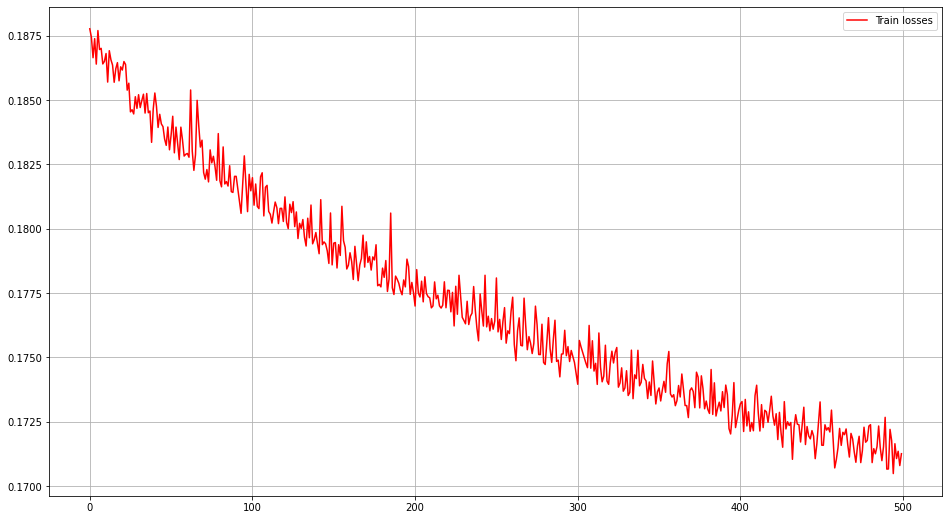

In [122]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_losses, color='red', label='Train losses')
# plt.axhline(1)
plt.grid()
plt.legend()

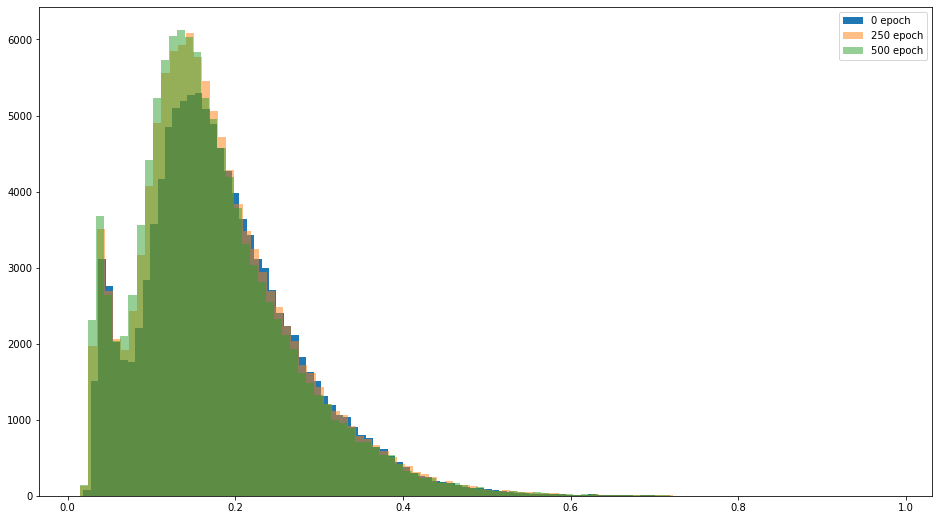

In [246]:
a = np.array(split_1_sample_mse_by_epoch)
epoch_1 = a[0, :, 1]
epoch_250 = a[250, :, 1]
epoch_500 = a[-1, :, 1]

plt.figure(figsize=(16, 9))
plt.hist(epoch_1, bins=100, label='0 epoch')
plt.hist(epoch_250, bins=100, label='250 epoch', alpha=0.5)
plt.hist(epoch_500, bins=100, label='500 epoch', alpha=0.5)
# plt.ylim(0, 20)
# plt.xlim(0, 0.2)
plt.legend()
plt.show()

### Forgetting Time

In [203]:
def forgetting_time_from_ssim(split_1_sample_scores_by_epoch, dataset, thr=0.5):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_scores_by_epoch), total=len(split_1_sample_scores_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score > thr:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score < thr and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step

def forgetting_time_from_mse(split_1_sample_scores_by_epoch, dataset, thr=0.65):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_scores_by_epoch), total=len(split_1_sample_scores_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score < thr:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score > thr and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step


In [204]:
forgetting_times_ssim, fogetting_times_ssim_steps = forgetting_time_from_ssim(split_1_sample_ssim_by_epoch, split_1_ds, thr=0.5)
forgetting_times_mse, fogetting_times_mse_steps = forgetting_time_from_mse(split_1_sample_mse_by_epoch, split_1_ds)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [207]:
split_1_forgetting_time_df = pd.DataFrame(
    [(idx, fogetting_times_ssim_steps[idx], fogetting_times_mse_steps[idx]) for idx in fogetting_times_ssim_steps.keys()],
    columns = ['sample_idx', 'ssim_forgetting_time', 'mse_forgetting_time']
)

# Analysis

In [240]:
to_comp = 'ssim' # scores/preds
ft_metric = f'{to_comp}_forgetting_time'
lt_metric = f'{to_comp}_learning_time'

curr_split_ds = split_1_ds

metrics_df = pd.merge(split_1_metrics_df, split_1_forgetting_time_df, on='sample_idx')
never_forgotten_thr = metrics_df[ft_metric].max() + 5000
metrics_df.loc[metrics_df[ft_metric] == -1, ft_metric] = never_forgotten_thr + 5000

In [241]:
shuffled_idx_2_original_idx = {i : x for i, x in enumerate(curr_split_ds.dataset.indices)}
metrics_df['original_sample_idx'] = metrics_df.sample_idx.apply(lambda x: shuffled_idx_2_original_idx[x])

In [242]:
# corrupted_indices = curr_split_ds.dataset.dataset.corrupted_indices
corrupted_indices = list(curr_split_ds.dataset.dataset.dataset.dd_idxs_aug.keys())
metrics_df['is_mislabeled'] = False
metrics_df.loc[metrics_df.original_sample_idx.isin(corrupted_indices), 'is_mislabeled'] = True

In [243]:
# metrics_df.to_csv('./cnn_225k_mnist_sup_metrics_split_2.csv', index=False)

In [244]:
learning_time = metrics_df[lt_metric].values
forgetting_time = metrics_df[ft_metric].values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


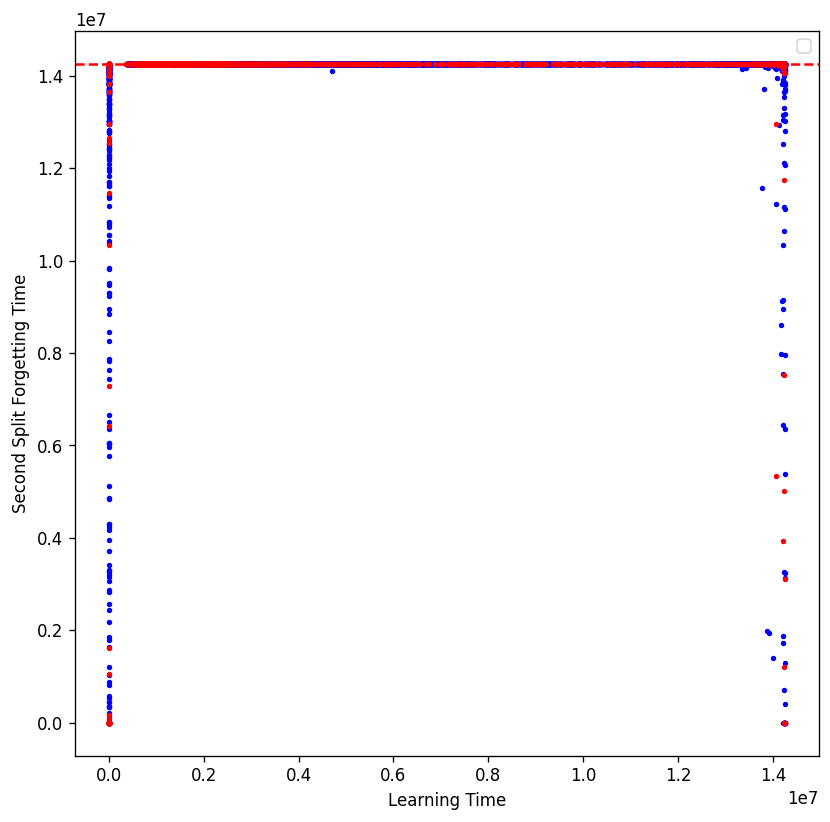

In [245]:
plt.figure(figsize=(8, 8), dpi=120)

# plt.scatter(learning_time, forgetting_time,
#             s=5)

plt.scatter(learning_time[metrics_df[~metrics_df.is_mislabeled].index], forgetting_time[metrics_df[~metrics_df.is_mislabeled].index],
            s=5, c='blue')
plt.scatter(learning_time[metrics_df[metrics_df.is_mislabeled].index], forgetting_time[metrics_df[metrics_df.is_mislabeled].index],
            s=5, c='r')

plt.axhline(y=never_forgotten_thr, linestyle='dashed', c='red')
plt.xlabel('Learning Time')
plt.ylabel('Second Split Forgetting Time')
plt.legend()
plt.show()


In [148]:
mislabeled_subset = metrics_df[(metrics_df[lt_metric] > 1.75e6) & (metrics_df[ft_metric] < 0.5e6)].sample_idx.values
ambigious_subset = metrics_df[(metrics_df[lt_metric] < 0.5e6) & (metrics_df[ft_metric] < 0.5e6)].sample_idx.values
typical_subset = metrics_df[(metrics_df[lt_metric] < 0.5e6) & (metrics_df[ft_metric] > 2.5e6)].sample_idx.values
atypical_subset = metrics_df[(metrics_df[lt_metric] > 2e6) & (metrics_df[ft_metric] > 2.5e6)].sample_idx.values

# split1_ds[2]

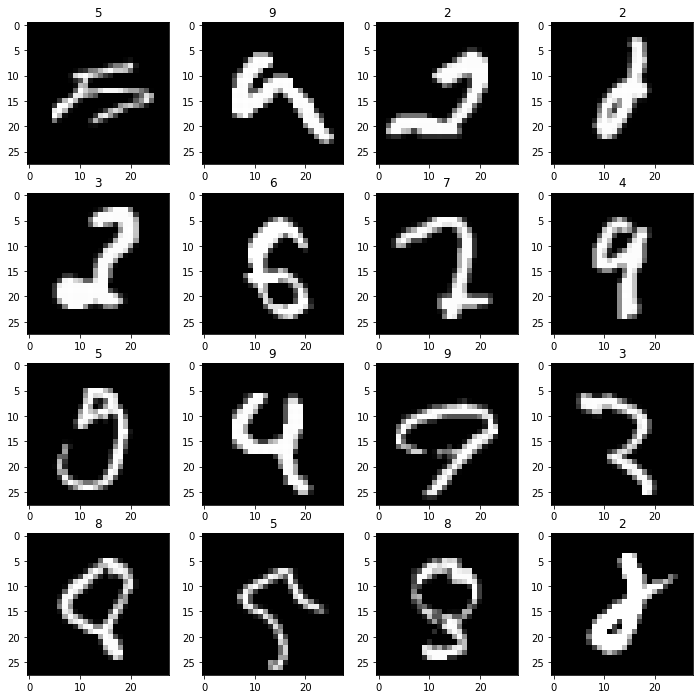

In [149]:
subset = ambigious_subset
# subset = [3845, 55894]

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()

for i in range(len(subset)):
    if i >= 16:
        break
    
    idx = subset[i]
    
    unnormalize = lambda x: x*0.3081 + 0.1307
    
    _, img, label = curr_split_ds[idx]
    np_img = (unnormalize(img.squeeze().numpy())*255).astype(int)

    ax[i].imshow(np_img, cmap='gray')
    ax[i].set_title(label)

# Classification

In [176]:
m1 = pd.read_csv('./cnn_225k_mnist_sup_metrics.csv')
m2 = pd.read_csv('./cnn_225k_mnist_sup_metrics_split_2.csv')

In [177]:
m = pd.concat([m1, m2]).reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


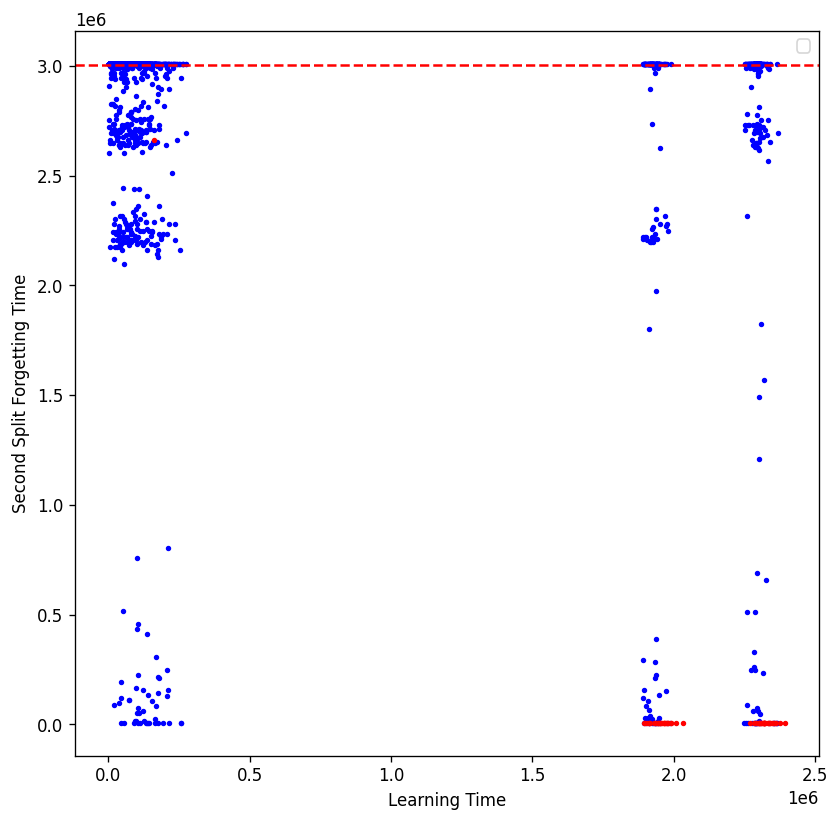

In [178]:
learning_time = m[lt_metric]
forgetting_time = m[ft_metric]
df = m

plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(learning_time[df[~df.is_mislabeled].index], forgetting_time[df[~df.is_mislabeled].index],
            s=5, c='blue')
plt.scatter(learning_time[df[df.is_mislabeled].index], forgetting_time[df[df.is_mislabeled].index],
            s=5, c='r')
plt.axhline(y=never_forgotten_thr, linestyle='dashed', c='red')
plt.xlabel('Learning Time')
plt.ylabel('Second Split Forgetting Time')
plt.legend()
plt.show()


In [182]:
df['prediction'] = 'none'
df.loc[(df[lt_metric] > 1.25e6) & (df[ft_metric] < 1.5e6), 'prediction'] = 'mislabeled'
df.loc[(df[lt_metric] < 1.25e6) & (df[ft_metric] < 1.5e6), 'prediction'] = 'ambigious'
df.loc[(df[lt_metric] < 1.25e6) & (df[ft_metric] > 1.5e6), 'prediction'] = 'typical'
df.loc[(df[lt_metric] > 1.25e6) & (df[ft_metric] > 1.5e6), 'prediction'] = 'atypical'

In [202]:
df[df.prediction == 'mislabeled'].is_mislabeled.value_counts()

False    70
True     59
Name: is_mislabeled, dtype: int64

In [194]:
df

,index,sample_idx,scores_learning_time,preds_learning_time,scores_forgetting_time,preds_forgetting_time,original_sample_idx,is_mislabeled,prediction
0,0,26028,59367,59367,3010000,-1,39689,False,typical
1,1,6792,34998,34998,3010000,-1,28623,False,typical
2,2,2966,32257,32257,3010000,-1,58165,False,typical
3,3,27994,36990,3,3010000,-1,15180,False,typical
4,4,13494,47702,47702,3010000,-1,29298,False,typical
...,...,...,...,...,...,...,...,...,...
59995,29995,21594,29995,-1,3010000,0,9761,False,typical
59996,29996,14195,29996,-1,3010000,0,41028,False,typical
59997,29997,14053,29997,-1,3010000,0,3277,False,typical
59998,29998,22408,29998,-1,3010000,0,51903,False,typical


In [192]:
df.to_csv('./cnn225k_mnist_sup_both_splits.csv', index=False)

# TODO

1. Syntetic label flips
2. Сложить картинки и получить зашумленные картинки
3. Посмотреть корреляции с метриками
4. Уменьшить LR –> больше шагов/деталей
5. Подумать над другими метриками
6. Далее посмотреть на корреляцию с другими методами выделения аутлаеров